## Recurent Neural Network

### Dataset import

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/NARMA10.csv", header=None)
X, Y =  torch.tensor(df.iloc[0]),  torch.tensor(df.iloc[1])

X.shape, Y.shape

(torch.Size([10000]), torch.Size([10000]))

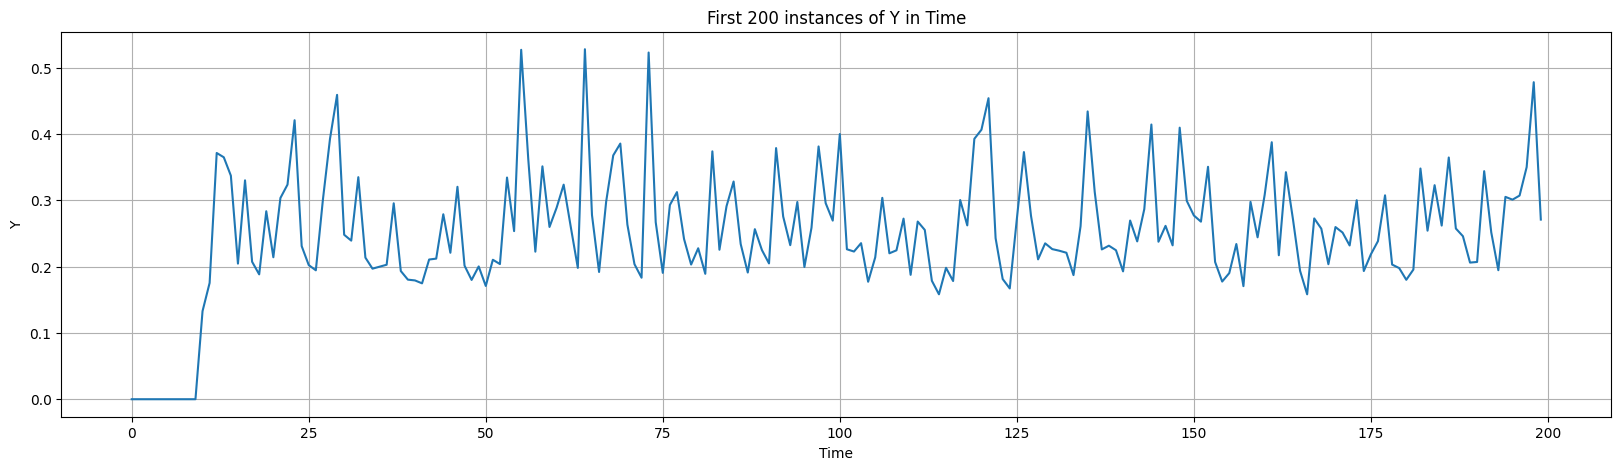

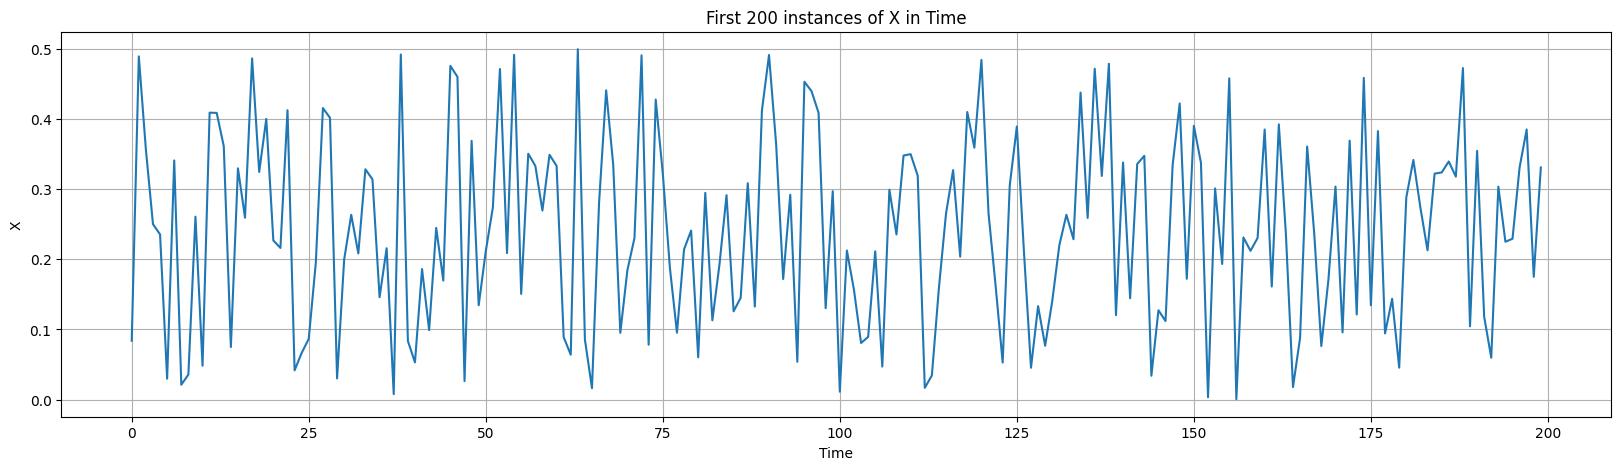

In [2]:
from utils import plot_time_series

time = torch.arange(0, X.shape[0])

plot_time_series(time, Y, "First 200 instances of Y in Time", "Time", "Y", 200)
plot_time_series(time, X, "First 200 instances of X in Time", "Time", "X", 200)
    

### Data Split

In [3]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(-1, 1).float()
x_val = x_val.reshape(-1, 1).float()
x_test = x_test.reshape(-1, 1).float()

y_train = y_train.reshape(-1, 1).float()
y_val = y_val.reshape(-1, 1).float()
y_test = y_test.reshape(-1, 1).float()

print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([4000, 1])
Validation set shape: torch.Size([1000, 1])
Test set shape: torch.Size([5000, 1])


### Model Assessment

#### Parameters download

In [4]:
from utils import import_parameters

config, _ = import_parameters("rnn.yaml")

#### Model Random Grid Search

In [5]:
from learning import parallel_grid_search

best_model, t_history, v_history, best_params = parallel_grid_search(
    model="RNN",
    n_iter=10,
    config=config,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    seed=42,
    n_jobs=-1
)

RNN Grid Search: 100%|██████████| 10/10 [00:00<00:00, 42.53it/s]


Best validation loss: 0.002608786802738905


In [6]:
print("Best Parameters:")
for key, value in best_params.items():
    print(f" {key}: {value}")

Best Parameters:
 hidden_size: 16
 num_layers: 3
 non_linearity: tanh
 dropout: 0.0
 bidirectional: False
 lr: 0.01
 weight_decay: 0.0
 epochs: 250
 patience: 30
 delta: 1e-5


#### Training and Validation loss

Training Loss: 0.002930297749117017
Validation Loss: 0.0026679676957428455


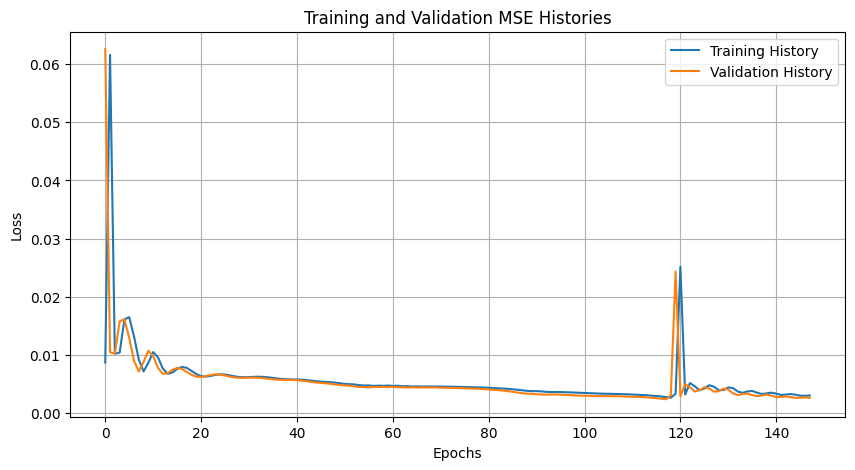

In [10]:
from torch import nn
from utils import plot_histories

train_loss = nn.MSELoss()(best_model.forward(x_train, None), y_train)
print(f"Training Loss: {train_loss.item()}")

val_loss = nn.MSELoss()( best_model.forward(x_val, None)[0], y_val)
print(f"Validation Loss: {val_loss.item()}")
plot_histories(t_history, v_history)

#### Model Retraining

In [13]:
x_retrain = torch.cat((x_train, x_val), dim=0)
y_retrain = torch.cat((y_train, y_val), dim=0)

ret_history, test_history = best_model.fit(
    x_train = x_retrain,
    y_train = y_retrain,
    x_val = x_test,
    y_val = y_test,
    epochs = int(best_params['epochs']),
    lr = float(best_params['lr']),
    weight_decay = float(best_params['weight_decay']),
    patience = int(best_params['patience']),
    delta = float(best_params['delta']),
    verbose = True,
)

Epoch 50/250, Train Loss: 0.011035229079425335, Val Loss: 0.0035685081966221333
Early stopping at epoch 77


#### Re-training and Test loss over time plot

Retraining Loss: 0.00012453996168915182
Test Loss: 0.0001333266554865986


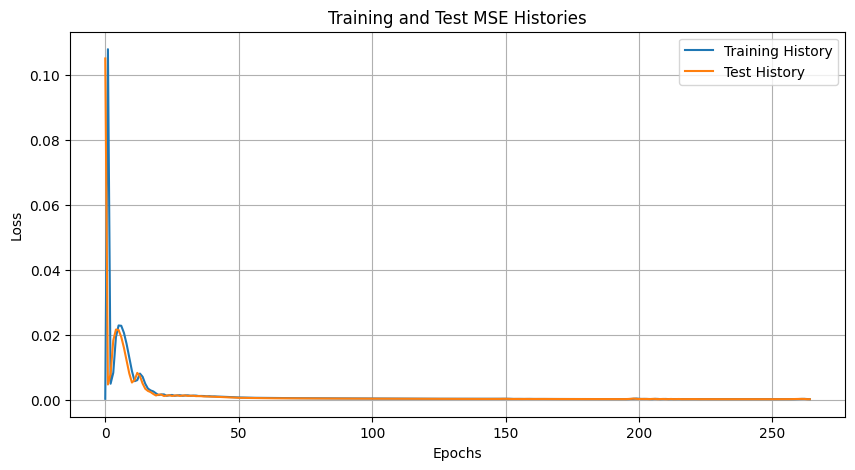

In [ ]:
from utils import plot_histories

retrain_loss = nn.MSELoss()(best_model.forward(x_retrain), y_retrain)
print(f"Retraining Loss: {retrain_loss.item()}")

test_loss = nn.MSELoss()(best_model.forward(x_test), y_test)
print(f"Test Loss: {test_loss.item()}")

plot_histories(ret_history, test_history, val_set='Test')

#### Target vs Output signal for Training and test set

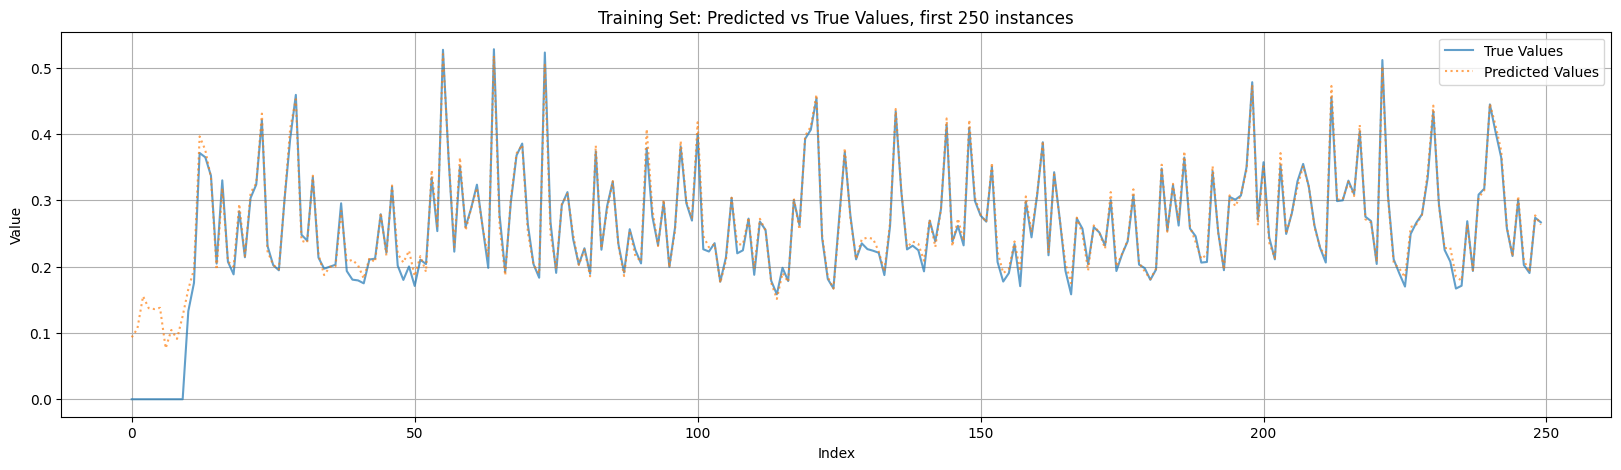

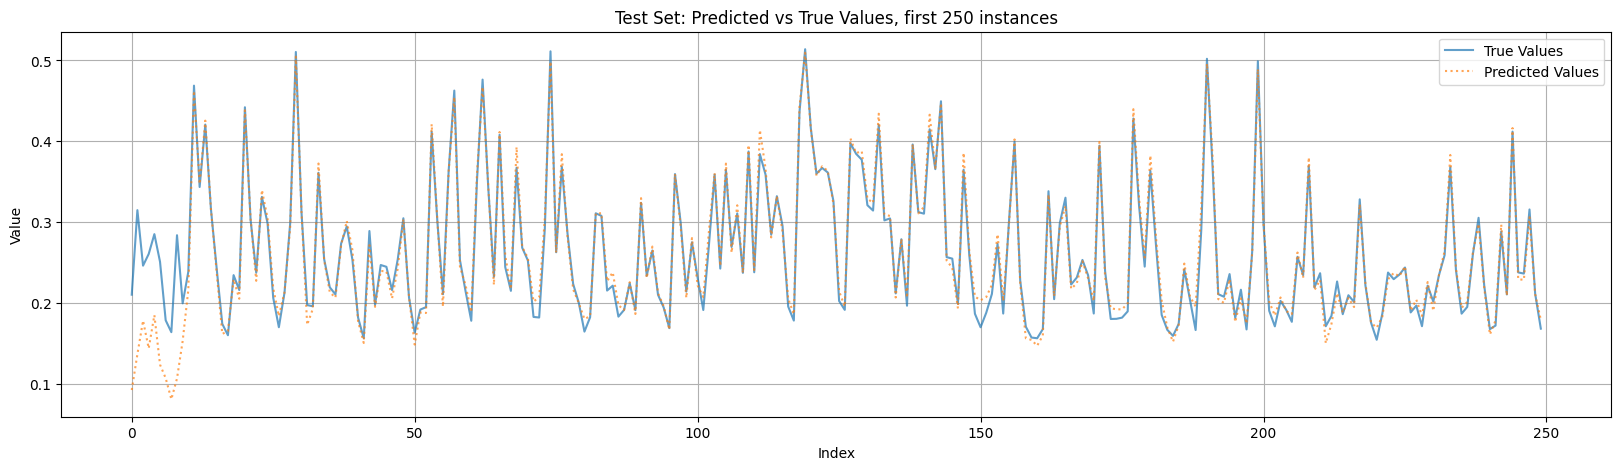

In [ ]:
from utils import plot_predictions


y_train_pred = best_model.forward(x_retrain)
plot_predictions(y_train, y_train_pred, "Training Set: Predicted vs True Values, first 250 instances", 250)

y_test_pred = best_model.forward(x_test)
plot_predictions(y_test, y_test_pred, "Test Set: Predicted vs True Values, first 250 instances", 250)
